# Assignment 

In this challenge, we will work with the [Life Expectancy](https://www.kaggle.com/kumarajarshi/life-expectancy-who) dataset from Kaggle. The data is collected from the websites of the World Health Organisation (WHO) and World Bank (WB). The dataset contains annual variables for many of the countries in the world which are divided into several broad categories: immunization related factors, mortality factors, economical factors, and social factors.

Our goal in this challenge is to find the factors that affect the __life expectancy__. Specifically, we need to find out which factors increase the expected life in the countries and which factors decrease it.

In [1]:
# Libraries 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from sklearn.decomposition import PCA 
from sqlalchemy import create_engine
import warnings
import pandas_profiling as pp
import missingno as msno

warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db, table_name))

lifeexpectancy_df = pd.read_sql_query('select * from lifeexpectancy',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

## Data Cleaning 

We will begin the exploratory data analysis process by cleaning the data. First, we will take the raw dataset and eliminate problems which would prevent us from further analysis such as inconsistent column names and identifying missing values.  

In [2]:
# Rename columns that contain trailing spaces

df = lifeexpectancy_df.copy()

df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('__', '_').str.replace('(', '').str.replace(')', '')

df.head()


,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,...,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_1-19_years,thinness_5-9_years,income_composition_of_resources,schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [3]:
# Verify data types 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
country                            2938 non-null object
year                               2938 non-null int64
status                             2938 non-null object
life_expectancy                    2928 non-null float64
adult_mortality                    2928 non-null float64
infant_deaths                      2938 non-null int64
alcohol                            2744 non-null float64
percentage_expenditure             2938 non-null float64
hepatitis_b                        2385 non-null float64
measles                            2938 non-null int64
bmi                                2904 non-null float64
under-five_deaths                  2938 non-null int64
polio                              2919 non-null float64
total_expenditure                  2712 non-null float64
diphtheria                         2919 non-null float64
hiv/aids                           2938 non-null

This dataset has 22 attributes. Majority of the attributes are continuous ratio variables, such as the target variable, life expectancy. There are two nominal categorical variables that describe life expectancy, status and country. 

We will continue exploring the data by search for missing values. Then, we will fill in the missing values with the appropriate technique.


In [4]:
# Percentage of missing values 

df.isnull().sum()*100/df.isnull().count()

country                             0.000000
year                                0.000000
status                              0.000000
life_expectancy                     0.340368
adult_mortality                     0.340368
infant_deaths                       0.000000
alcohol                             6.603131
percentage_expenditure              0.000000
hepatitis_b                        18.822328
measles                             0.000000
bmi                                 1.157250
under-five_deaths                   0.000000
polio                               0.646698
total_expenditure                   7.692308
diphtheria                          0.646698
hiv/aids                            0.000000
gdp                                15.248468
population                         22.191967
thinness_1-19_years                 1.157250
thinness_5-9_years                  1.157250
income_composition_of_resources     5.684139
schooling                           5.547992
dtype: flo

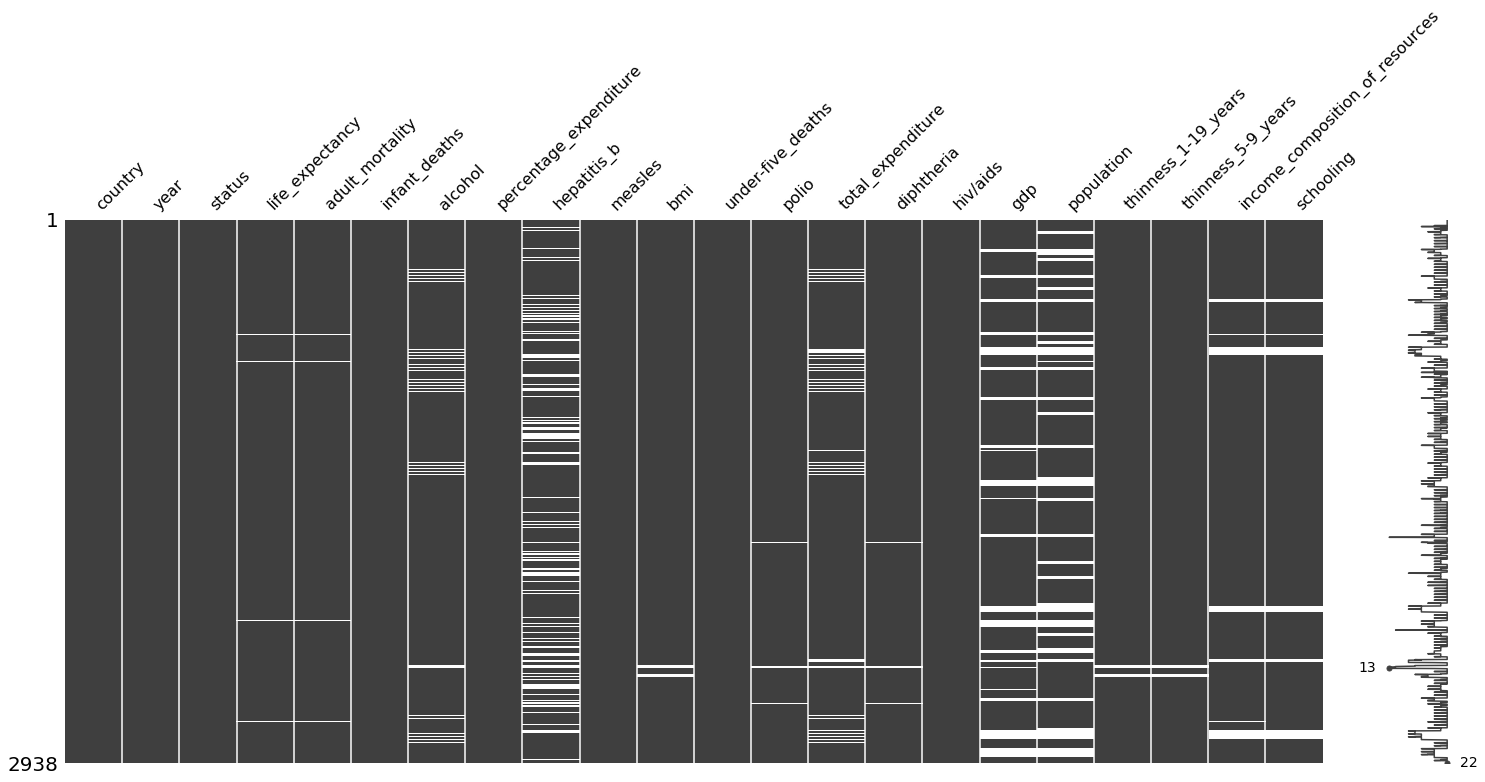

In [5]:
# Create nullity matrix for missing values 

msno.matrix(df)

We can see that there are multiple missing values in majority of the columns. Population, hepatitis b, and GDP are missing more than 10% of datapoints. We can also observe that there is an overlap of where GDP and population have missing values. The white bands in both of these columns are relatively thicker than in other columns. An explanation of the thickness of these bands might be due to the row organization of the dataset. As shown in the sample dataset above, the rows are arranged by groups of each country's data collected from 2011 to 2015. Missing data from 2011 may have never been updated, thus leaving groups of rows appearing as null. 

Since the rows in this dataset is grouped by countries and the data is timeseries, we will use interpolation to fill in the missing values. The interpolate function will perform a linear interpolation at the missing data points to “guess” the value that is most likely to be filled in.

In [6]:
# Replace missing values with interpolation 

null_val = ['life_expectancy','adult_mortality','alcohol','hepatitis_b',
           'bmi','polio','total_expenditure','diphtheria','gdp','population',
           'thinness_1-19_years','thinness_5-9_years','income_composition_of_resources',
           'schooling']

countries = df['country'].unique()

for country in countries:
    df.loc[df['country'] == country, null_val] = df.loc[df['country'] == country, null_val].interpolate()

# we drop the null values after interpolation
df.dropna(inplace=True)


In [7]:
# Check for null values 

df.isnull().sum()

country                            0
year                               0
status                             0
life_expectancy                    0
adult_mortality                    0
infant_deaths                      0
alcohol                            0
percentage_expenditure             0
hepatitis_b                        0
measles                            0
bmi                                0
under-five_deaths                  0
polio                              0
total_expenditure                  0
diphtheria                         0
hiv/aids                           0
gdp                                0
population                         0
thinness_1-19_years                0
thinness_5-9_years                 0
income_composition_of_resources    0
schooling                          0
dtype: int64

Since we have successfully filled in missing values, we will treat outliers in the following section. Let's run some descriptive statistics on the data before and after we interpolated missing values to see if there was signifcant change. 

In [8]:
lifeexpectancy_df.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938.000000,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,4.613841,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,2012.000000,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.60000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


In [9]:
df.describe()

,year,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_1-19_years,thinness_5-9_years,income_composition_of_resources,schooling
count,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1987.00000,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1.987000e+03,1987.000000,1987.000000,1987.000000,1987.000000
mean,2006.984902,67.981782,175.187217,36.623553,4.455644,685.492318,73.86160,2729.561651,36.428636,50.932562,80.371917,5.902728,80.454454,2.274937,5392.335709,1.358390e+07,5.129995,5.199346,0.603453,11.639054
std,4.323147,9.706401,131.616942,138.784913,3.976733,1761.669050,29.02807,12102.389143,19.736138,188.933117,24.363376,2.287467,24.450153,6.005112,11480.810350,6.490113e+07,4.750149,4.844382,0.206026,3.212964
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,2.00000,0.000000,1.400000,0.000000,3.000000,0.370000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2003.000000,61.700000,75.000000,1.000000,0.830000,29.469887,64.00000,0.000000,18.150000,1.000000,74.000000,4.360000,75.500000,0.100000,384.553107,1.967480e+05,1.600000,1.600000,0.473000,9.700000
50%,2007.000000,69.900000,153.000000,4.000000,3.770000,104.314473,86.00000,20.000000,38.700000,4.000000,91.000000,5.800000,91.000000,0.100000,1334.651896,1.396861e+06,3.300000,3.400000,0.648000,11.900000
75%,2011.000000,74.700000,243.000000,25.000000,7.190000,470.870122,95.00000,499.500000,55.000000,36.000000,96.000000,7.385000,96.000000,1.400000,4441.530655,7.625918e+06,7.600000,7.700000,0.745000,13.700000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,18961.348600,99.00000,212183.000000,77.100000,2500.000000,99.000000,14.390000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.936000,20.700000


After interploation, the mean of each column did shift in various degress. Columns with less than 5% of missing values experience less than 5% of change in mean. As expected the columns with the highest amounts of missing data recieved around 10% of change in mean. Overall, these changes are not as drastic so we will assume that the datapoints were missing at random. 

### Detect Outliers

As shown below, the variables are not normally distributed and there are multiple outliers in the dataset. To treat these outliers, we will use the Tukey method to statistically identify outliers.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12867bb70>,
      dtype=object)

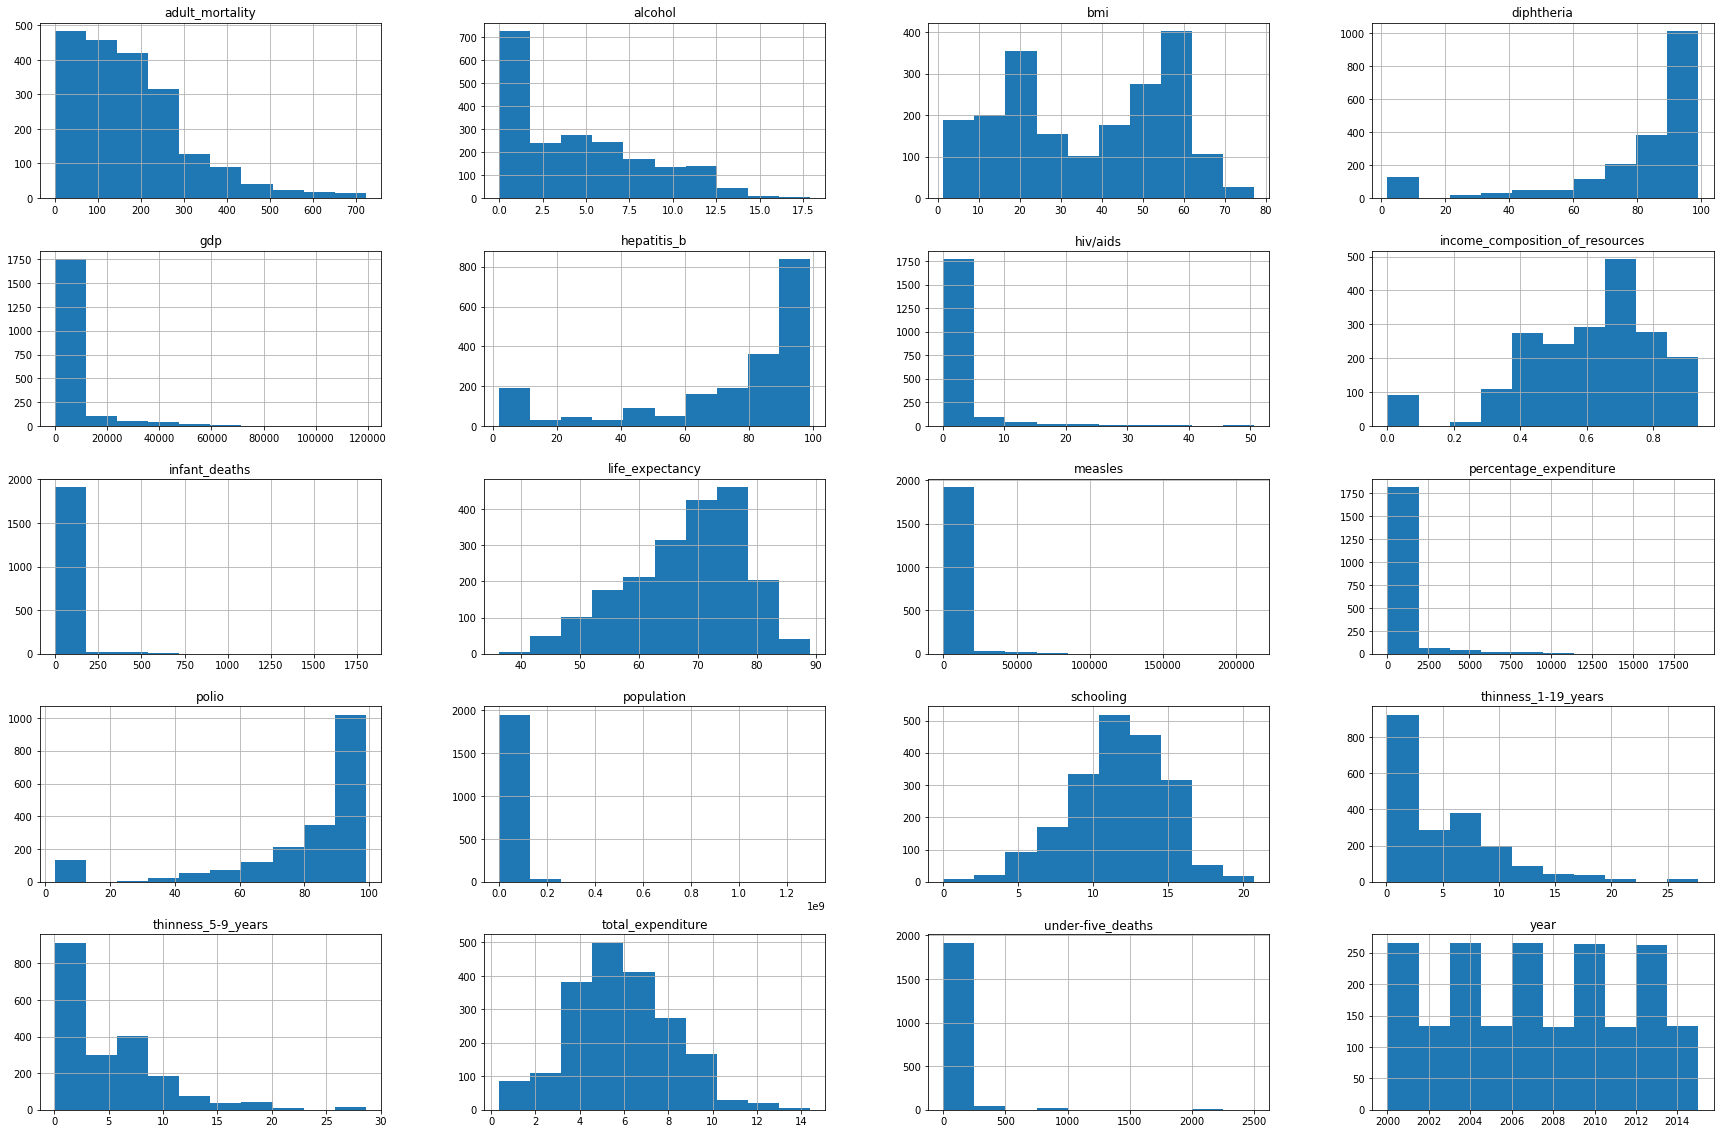

In [10]:
df.hist(figsize=(30,20))

In [11]:
# Dictionary of columns

col_dict = {'life_expectancy':1, 'adult_mortality': 2, 'infant_deaths':3,
          'alcohol':4, 'percentage_expenditure':5, 'hepatitis_b':6,
          'measles':7, 'bmi':8, 'under-five_deaths':9, 'polio':10,
          'total_expenditure':11, 'diphtheria':12, 'hiv/aids':13, 
          'gdp':14, 'population':15, 'thinness_1-19_years':16,
          'thinness_5-9_years':17, 'income_composition_of_resources':18,
          'schooling':19}

In [12]:
# Calculate number of outliers and its percentage in each variable using Tukey's method

for variable in col_dict.keys():
    q75, q25 = np.percentile(df[variable], [75 ,25])
    iqr = q75 - q25

    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    print("Number of outliers and percentage of it in {} : {} and {}".format(variable,
                                                                             len((np.where((df[variable] > max_val) | 
                                                                                           (df[variable] < min_val))[0])),len((np.where((df[variable] > max_val) | 
                                                                                           (df[variable] < min_val))[0]))*100/1987))

Number of outliers and percentage of it in life_expectancy : 4 and 0.20130850528434827
Number of outliers and percentage of it in adult_mortality : 58 and 2.9189733266230498
Number of outliers and percentage of it in infant_deaths : 198 and 9.96477101157524
Number of outliers and percentage of it in alcohol : 3 and 0.1509813789632612
Number of outliers and percentage of it in percentage_expenditure : 232 and 11.675893306492199
Number of outliers and percentage of it in hepatitis_b : 216 and 10.870659285354806
Number of outliers and percentage of it in measles : 361 and 18.16809260191243
Number of outliers and percentage of it in bmi : 0 and 0.0
Number of outliers and percentage of it in under-five_deaths : 227 and 11.424257674886764
Number of outliers and percentage of it in polio : 159 and 8.002013085052843
Number of outliers and percentage of it in total_expenditure : 13 and 0.6542526421741318
Number of outliers and percentage of it in diphtheria : 195 and 9.813789632611979
Number of

Next, we will remove the outliers by using the Winsorization technique to limit outliers at a certain threshold. 

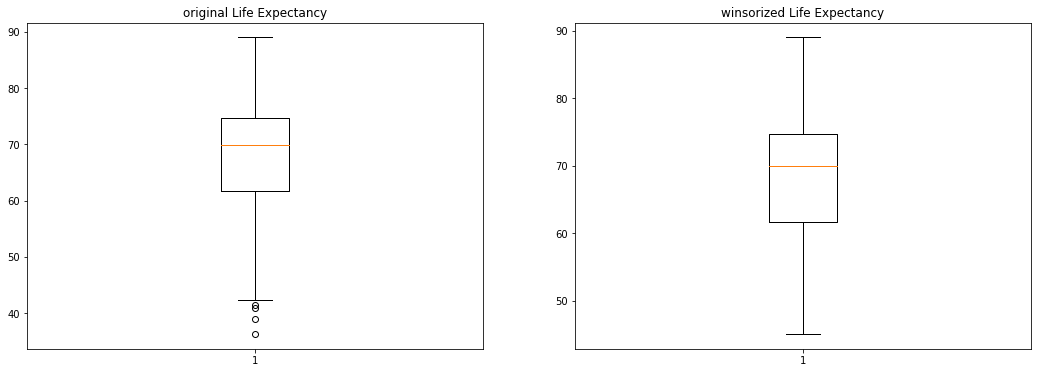

In [13]:
from scipy.stats.mstats import winsorize
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
life_expectancy = df['life_expectancy']
plt.boxplot(life_expectancy)
plt.title("original Life Expectancy")

plt.subplot(1,2,2)
winsorized_life_expectancy = winsorize(df['life_expectancy'],(0.01,0))
plt.boxplot(winsorized_life_expectancy)
plt.title("winsorized Life Expectancy")

plt.show()

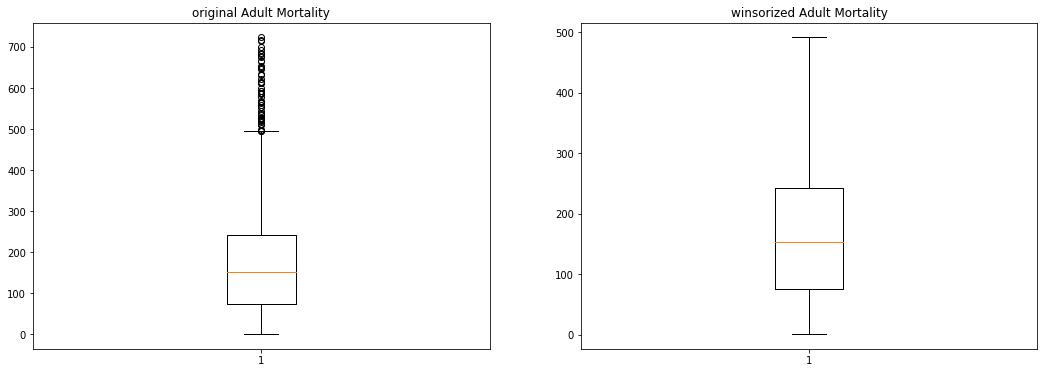

In [14]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
adult_mortality = df['adult_mortality']
plt.boxplot(adult_mortality)
plt.title("original Adult Mortality")

plt.subplot(1,2,2)
winsorized_adult_mortality = winsorize(df['adult_mortality'],(0,0.03))
plt.boxplot(winsorized_adult_mortality)
plt.title("winsorized Adult Mortality")

plt.show()

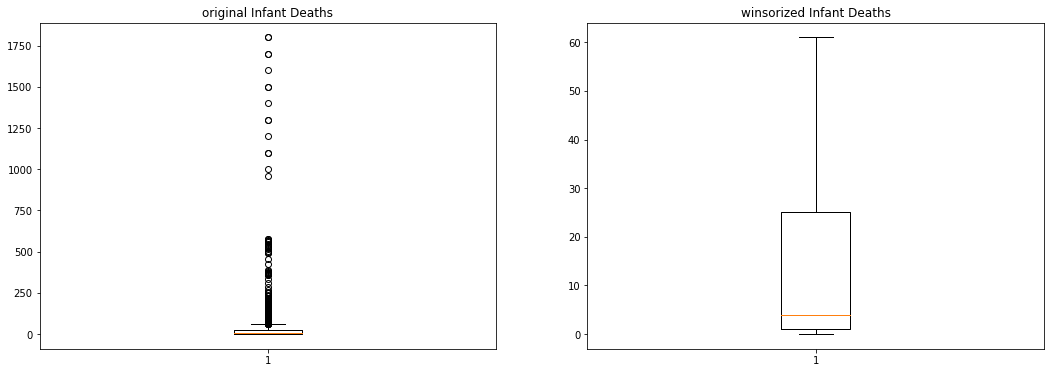

In [15]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
infant_deaths = df['infant_deaths']
plt.boxplot(infant_deaths)
plt.title("original Infant Deaths")

plt.subplot(1,2,2)
winsorized_infant_deaths = winsorize(df['infant_deaths'],(0,0.10))
plt.boxplot(winsorized_infant_deaths)
plt.title("winsorized Infant Deaths")

plt.show()

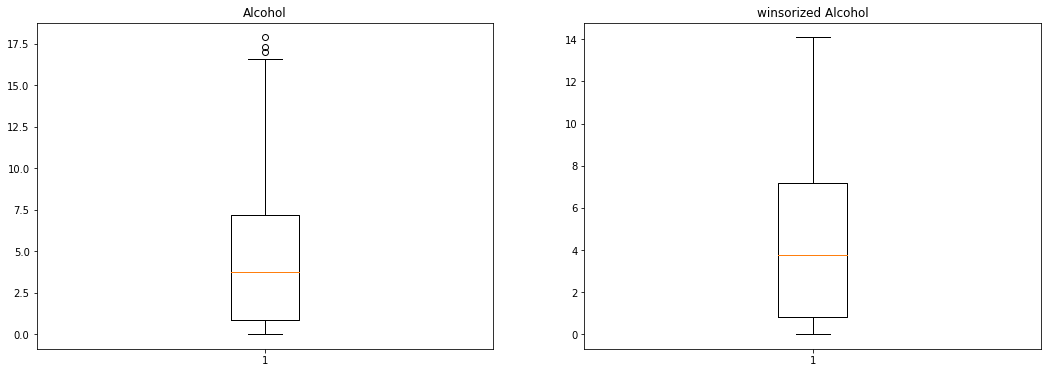

In [16]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
alcohol = df['alcohol']
plt.boxplot(alcohol)
plt.title("Alcohol")

plt.subplot(1,2,2)
winsorized_alcohol = winsorize(df['alcohol'],(0,0.01))
plt.boxplot(winsorized_alcohol)
plt.title("winsorized Alcohol")

plt.show()

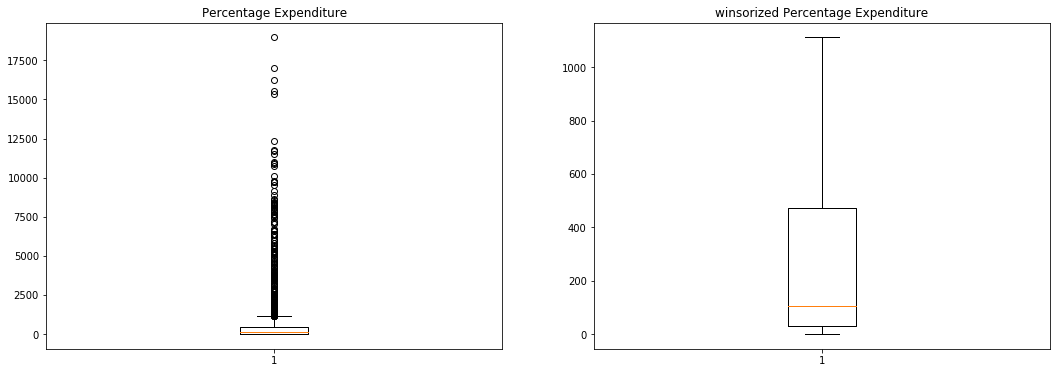

In [17]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
percentage_expenditure = df['percentage_expenditure']
plt.boxplot(percentage_expenditure)
plt.title("Percentage Expenditure")

plt.subplot(1,2,2)
winsorized_percentage_expenditure = winsorize(df['percentage_expenditure'],(0,0.12))
plt.boxplot(winsorized_percentage_expenditure)
plt.title("winsorized Percentage Expenditure")

plt.show()

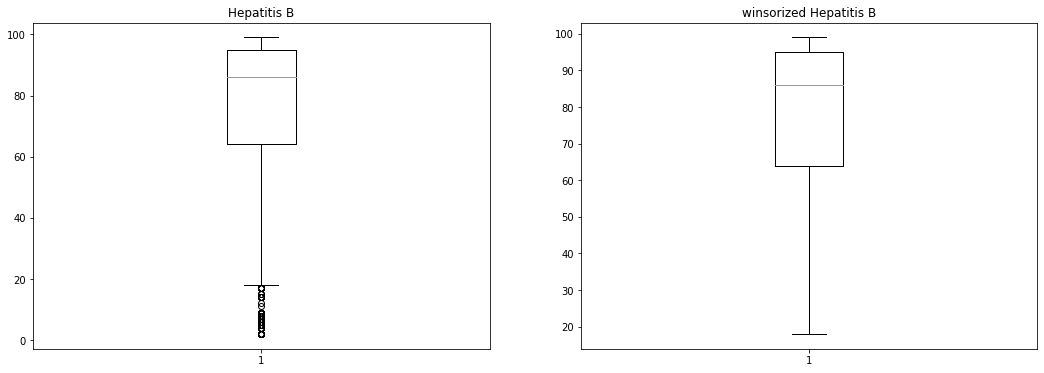

In [18]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
hepatitis_b = df['hepatitis_b']
plt.boxplot(hepatitis_b)
plt.title("Hepatitis B")

plt.subplot(1,2,2)
winsorized_hepatitis_b = winsorize(df['hepatitis_b'],(0.11,0))
plt.boxplot(winsorized_hepatitis_b)
plt.title("winsorized Hepatitis B")

plt.show()

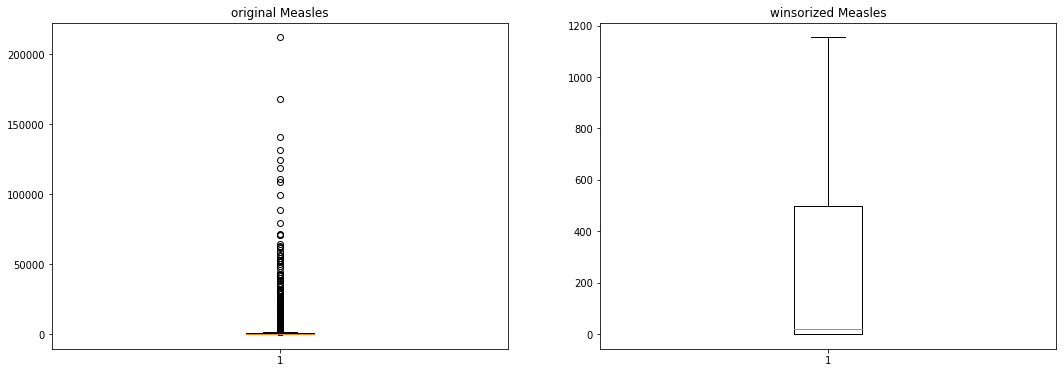

In [19]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
measles = df['measles']
plt.boxplot(measles)
plt.title("original Measles")

plt.subplot(1,2,2)
winsorized_measles = winsorize(df['measles'],(0,0.19))
plt.boxplot(winsorized_measles)
plt.title("winsorized Measles")

plt.show()

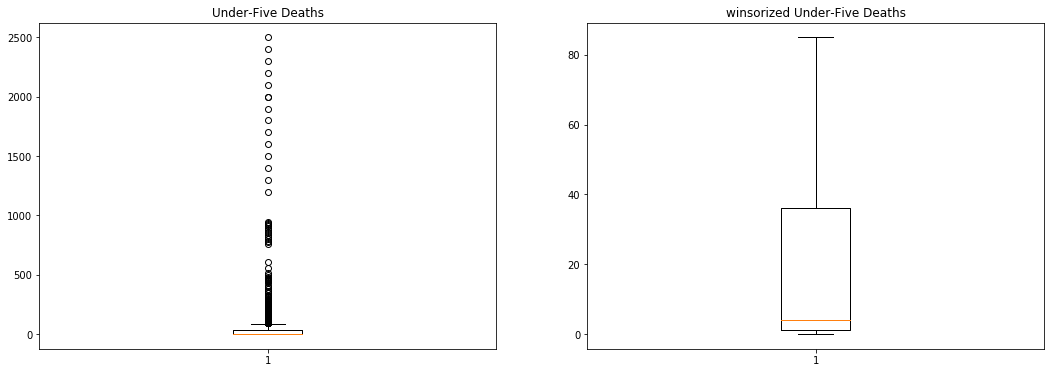

In [20]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
under_five_deaths = df['under-five_deaths']
plt.boxplot(under_five_deaths)
plt.title("Under-Five Deaths")

plt.subplot(1,2,2)
winsorized_under_five_deaths = winsorize(df['under-five_deaths'],(0,0.12))
plt.boxplot(winsorized_under_five_deaths)
plt.title("winsorized Under-Five Deaths")

plt.show()

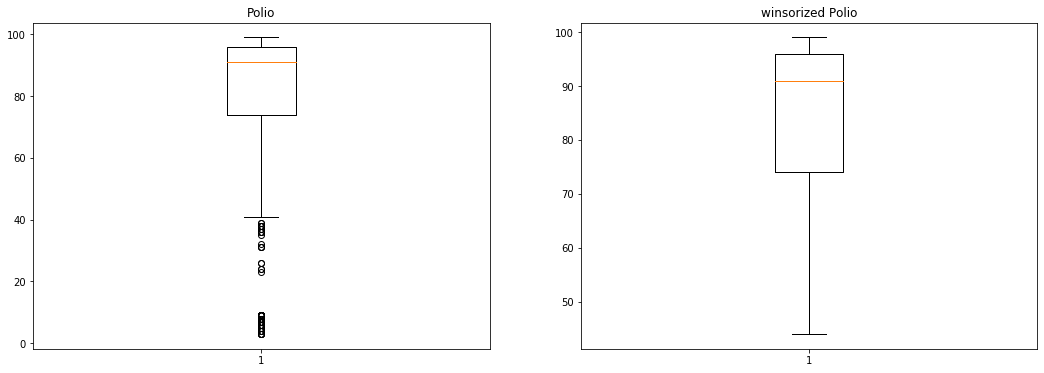

In [21]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
polio = df['polio']
plt.boxplot(polio)
plt.title("Polio")

plt.subplot(1,2,2)
winsorized_polio = winsorize(df['polio'],(0.09,0))
plt.boxplot(winsorized_polio)
plt.title("winsorized Polio")

plt.show()

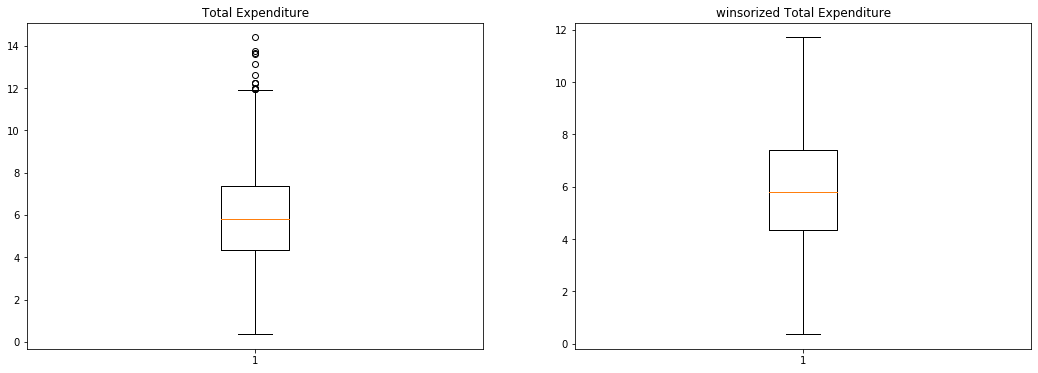

In [22]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
total_expenditure = df['total_expenditure']
plt.boxplot(total_expenditure)
plt.title("Total Expenditure")

plt.subplot(1,2,2)
winsorized_total_expenditure = winsorize(df['total_expenditure'],(0,0.01))
plt.boxplot(winsorized_total_expenditure)
plt.title("winsorized Total Expenditure")

plt.show()

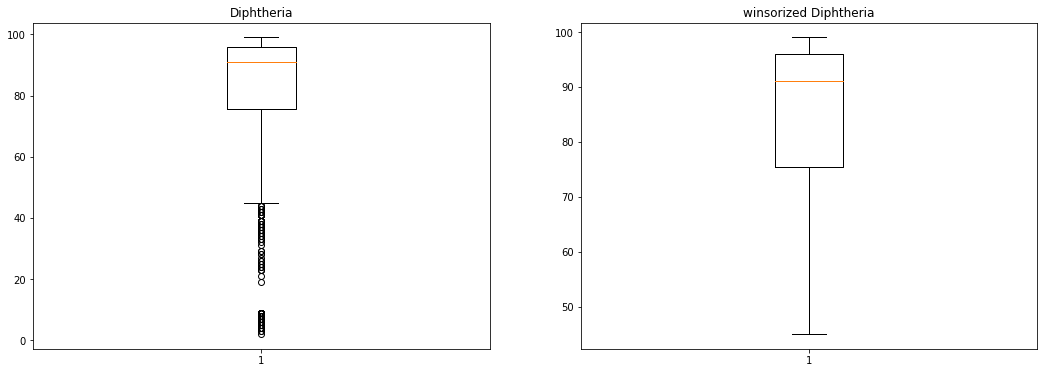

In [23]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
diphtheria = df['diphtheria']
plt.boxplot(diphtheria)
plt.title("Diphtheria")

plt.subplot(1,2,2)
winsorized_diphtheria = winsorize(df['diphtheria'],(0.10,0))
plt.boxplot(winsorized_diphtheria)
plt.title("winsorized Diphtheria")

plt.show()

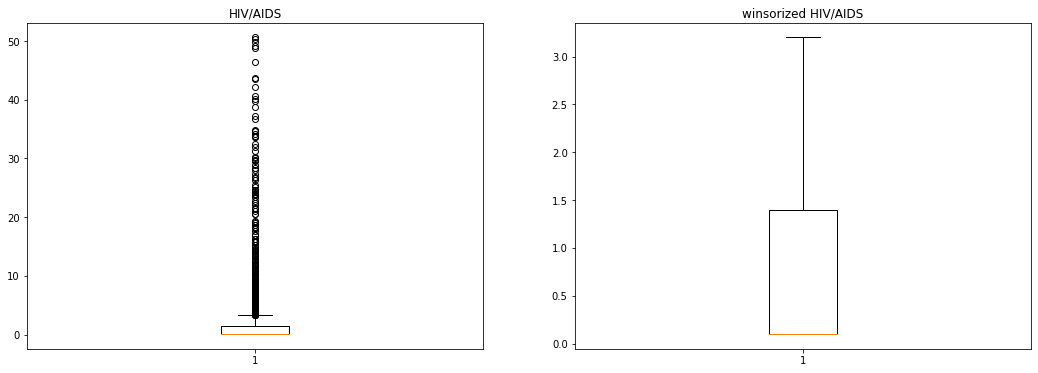

In [24]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
hiv_aids = df['hiv/aids']
plt.boxplot(hiv_aids)
plt.title("HIV/AIDS")

plt.subplot(1,2,2)
winsorized_hiv_aids = winsorize(df['hiv/aids'],(0,0.16))
plt.boxplot(winsorized_hiv_aids)
plt.title("winsorized HIV/AIDS")

plt.show()

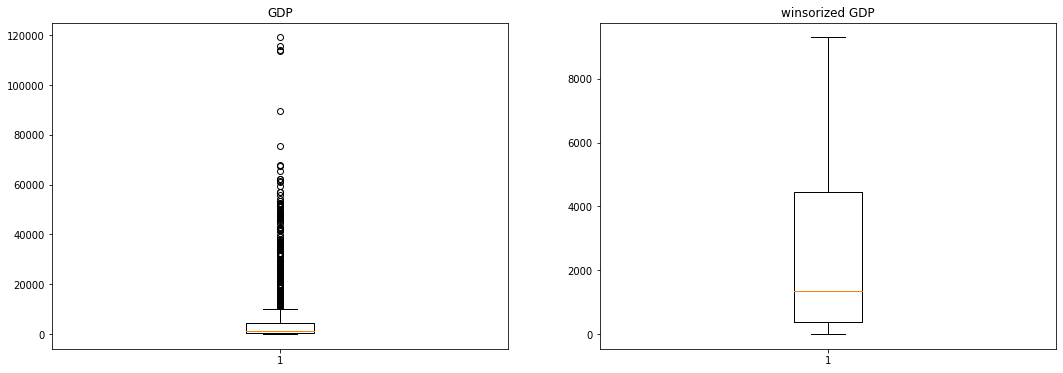

In [25]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
gdp = df['gdp']
plt.boxplot(gdp)
plt.title("GDP")

plt.subplot(1,2,2)
winsorized_gdp = winsorize(df['gdp'],(0,0.13))
plt.boxplot(winsorized_gdp)
plt.title("winsorized GDP")

plt.show()

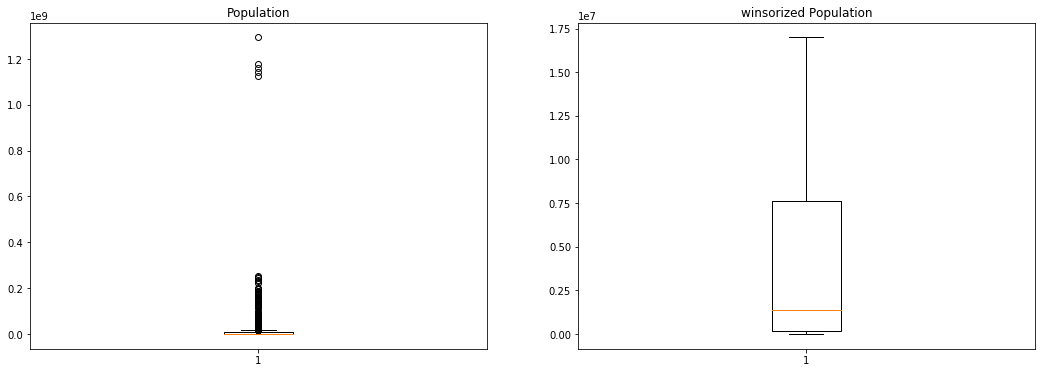

In [26]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
population = df['population']
plt.boxplot(population)
plt.title("Population")

plt.subplot(1,2,2)
winsorized_population = winsorize(df['population'],(0,0.14))
plt.boxplot(winsorized_population)
plt.title("winsorized Population")

plt.show()

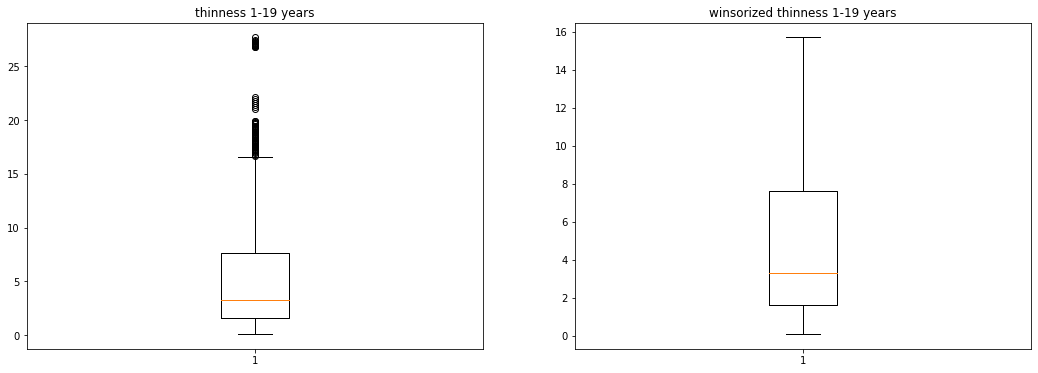

In [27]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
thinness_1_19_years = df['thinness_1-19_years']
plt.boxplot(thinness_1_19_years)
plt.title("thinness 1-19 years")

plt.subplot(1,2,2)
winsorized_thinness_1_19_years = winsorize(df['thinness_1-19_years'],(0,0.04))
plt.boxplot(winsorized_thinness_1_19_years)
plt.title("winsorized thinness 1-19 years")

plt.show()

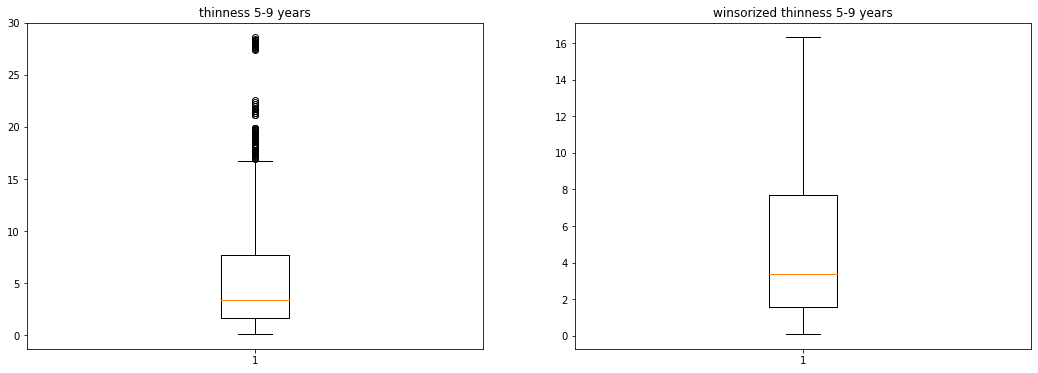

In [28]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
thinness_5_9_years = df['thinness_5-9_years']
plt.boxplot(thinness_5_9_years)
plt.title("thinness 5-9 years")

plt.subplot(1,2,2)
winsorized_thinness_5_9_years = winsorize(df['thinness_5-9_years'],(0,0.04))
plt.boxplot(winsorized_thinness_5_9_years)
plt.title("winsorized thinness 5-9 years")

plt.show()

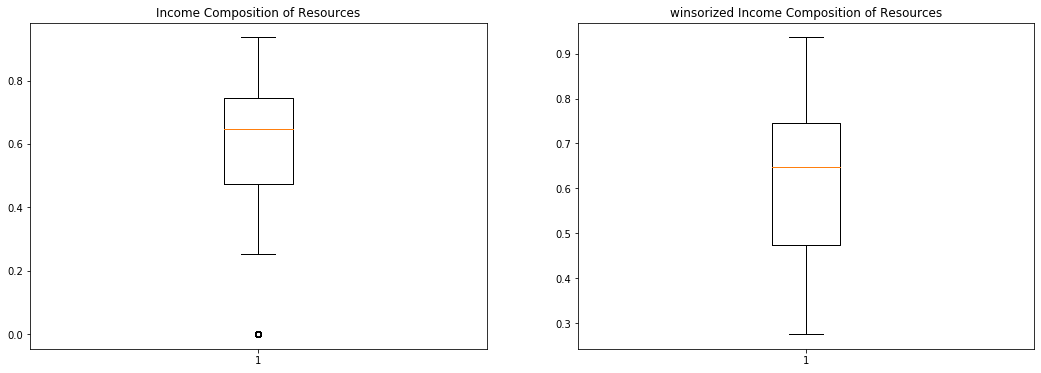

In [29]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
income_composition_of_resources = df['income_composition_of_resources']
plt.boxplot(income_composition_of_resources)
plt.title("Income Composition of Resources")

plt.subplot(1,2,2)
winsorized_income_composition_of_resources = winsorize(df['income_composition_of_resources'],(0.05,0))
plt.boxplot(winsorized_income_composition_of_resources)
plt.title("winsorized Income Composition of Resources")

plt.show()

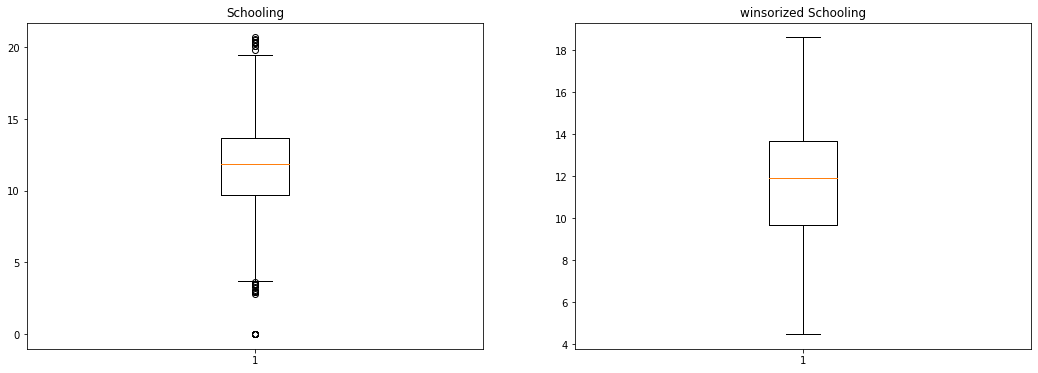

In [30]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
schooling = df['schooling']
plt.boxplot(schooling)
plt.title("Schooling")

plt.subplot(1,2,2)
winsorized_schooling = winsorize(df['schooling'],(0.02,0.01))
plt.boxplot(winsorized_schooling)
plt.title("winsorized Schooling")

plt.show()

In [31]:
# Check number of Outliers after Winsorization for each variable

win_list = [winsorized_life_expectancy,winsorized_adult_mortality,
            winsorized_infant_deaths,winsorized_alcohol,winsorized_percentage_expenditure,
            winsorized_hepatitis_b,winsorized_measles,winsorized_under_five_deaths,
            winsorized_polio,winsorized_total_expenditure,winsorized_diphtheria,
            winsorized_hiv_aids,winsorized_gdp,winsorized_population,winsorized_thinness_1_19_years,
            winsorized_thinness_5_9_years,winsorized_income_composition_of_resources,
            winsorized_schooling]

for variable in win_list:
    q75, q25 = np.percentile(variable, [75 ,25])
    iqr = q75 - q25

    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    
    print("Number of outliers after winsorization : {}".format(len(np.where((variable > max_val) | (variable < min_val))[0])))

Number of outliers after winsorization : 0
Number of outliers after winsorization : 0
Number of outliers after winsorization : 0
Number of outliers after winsorization : 0
Number of outliers after winsorization : 0
Number of outliers after winsorization : 0
Number of outliers after winsorization : 0
Number of outliers after winsorization : 0
Number of outliers after winsorization : 0
Number of outliers after winsorization : 0
Number of outliers after winsorization : 0
Number of outliers after winsorization : 0
Number of outliers after winsorization : 0
Number of outliers after winsorization : 0
Number of outliers after winsorization : 0
Number of outliers after winsorization : 0
Number of outliers after winsorization : 0
Number of outliers after winsorization : 0


In [32]:
# Add winsorized variable to the dataframe 

df['winsorized_life_expectancy'] = winsorized_life_expectancy
df['winsorized_adult_mortality'] = winsorized_adult_mortality
df['winsorized_infant_deaths'] = winsorized_infant_deaths
df['winsorized_alcohol'] = winsorized_alcohol
df['winsorized_percentage_expenditure'] = winsorized_percentage_expenditure
df['winsorized_hepatitis_b'] = winsorized_hepatitis_b
df['winsorized_measles'] = winsorized_measles
df['winsorized_under_five_deaths'] = winsorized_under_five_deaths
df['winsorized_polio'] = winsorized_polio
df['winsorized_total_expenditure'] = winsorized_total_expenditure
df['winsorized_diphtheria'] = winsorized_diphtheria
df['winsorized_hiv_aids'] = winsorized_hiv_aids
df['winsorized_gdp'] = winsorized_gdp
df['winsorized_population'] = winsorized_population
df['winsorized_thinness_1_19_years'] = winsorized_thinness_1_19_years
df['winsorized_thinness_5_9_years'] = winsorized_thinness_5_9_years
df['winsorized_income_composition_of_resources'] = winsorized_income_composition_of_resources
df['winsorized_schooling'] = winsorized_schooling


## Data Exploration

We will continue to explore the dataset by performing descriptive analysis to gain more insight. First, we will take a look at the distribution of continuous items and their relationship with life expectancy through scatterplots. 

In [33]:
# Get univariate statistics

df.describe()

,year,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under-five_deaths,...,winsorized_polio,winsorized_total_expenditure,winsorized_diphtheria,winsorized_hiv_aids,winsorized_gdp,winsorized_population,winsorized_thinness_1_19_years,winsorized_thinness_5_9_years,winsorized_income_composition_of_resources,winsorized_schooling
count,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1987.00000,1987.000000,1987.000000,1987.000000,...,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1.987000e+03,1987.000000,1987.000000,1987.000000,1987.000000
mean,2006.984902,67.981782,175.187217,36.623553,4.455644,685.492318,73.86160,2729.561651,36.428636,50.932562,...,82.957725,5.895471,83.225969,0.874082,2864.719760,4.799769e+06,4.955561,5.024006,0.616143,11.658581
std,4.323147,9.706401,131.616942,138.784913,3.976733,1761.669050,29.02807,12102.389143,19.736138,188.933117,...,17.556131,2.266421,17.239348,1.183198,3186.069874,6.217060e+06,4.187776,4.265385,0.174584,3.102260
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,2.00000,0.000000,1.400000,0.000000,...,44.000000,0.370000,45.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.276000,4.500000
25%,2003.000000,61.700000,75.000000,1.000000,0.830000,29.469887,64.00000,0.000000,18.150000,1.000000,...,74.000000,4.360000,75.500000,0.100000,384.553107,1.967480e+05,1.600000,1.600000,0.473000,9.700000
50%,2007.000000,69.900000,153.000000,4.000000,3.770000,104.314473,86.00000,20.000000,38.700000,4.000000,...,91.000000,5.800000,91.000000,0.100000,1334.651896,1.396861e+06,3.300000,3.400000,0.648000,11.900000
75%,2011.000000,74.700000,243.000000,25.000000,7.190000,470.870122,95.00000,499.500000,55.000000,36.000000,...,96.000000,7.385000,96.000000,1.400000,4441.530655,7.625918e+06,7.600000,7.700000,0.745000,13.700000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,18961.348600,99.00000,212183.000000,77.100000,2500.000000,...,99.000000,11.700000,99.000000,3.200000,9291.227619,1.699335e+07,15.700000,16.300000,0.936000,18.600000


The original dataset contains 22 numeric attributes. After treating outliers by using the winsorize method, 16 columns have been added. We can see the impact that outliers have on each variable when comparing the original mean to the winsorized mean. While some means have slightly changed, such as adult mortality, other means have drastically decreased, such as infant deaths from a mean of 36.6 to  15.5. 

Next, we'll start visualizing the distributions.

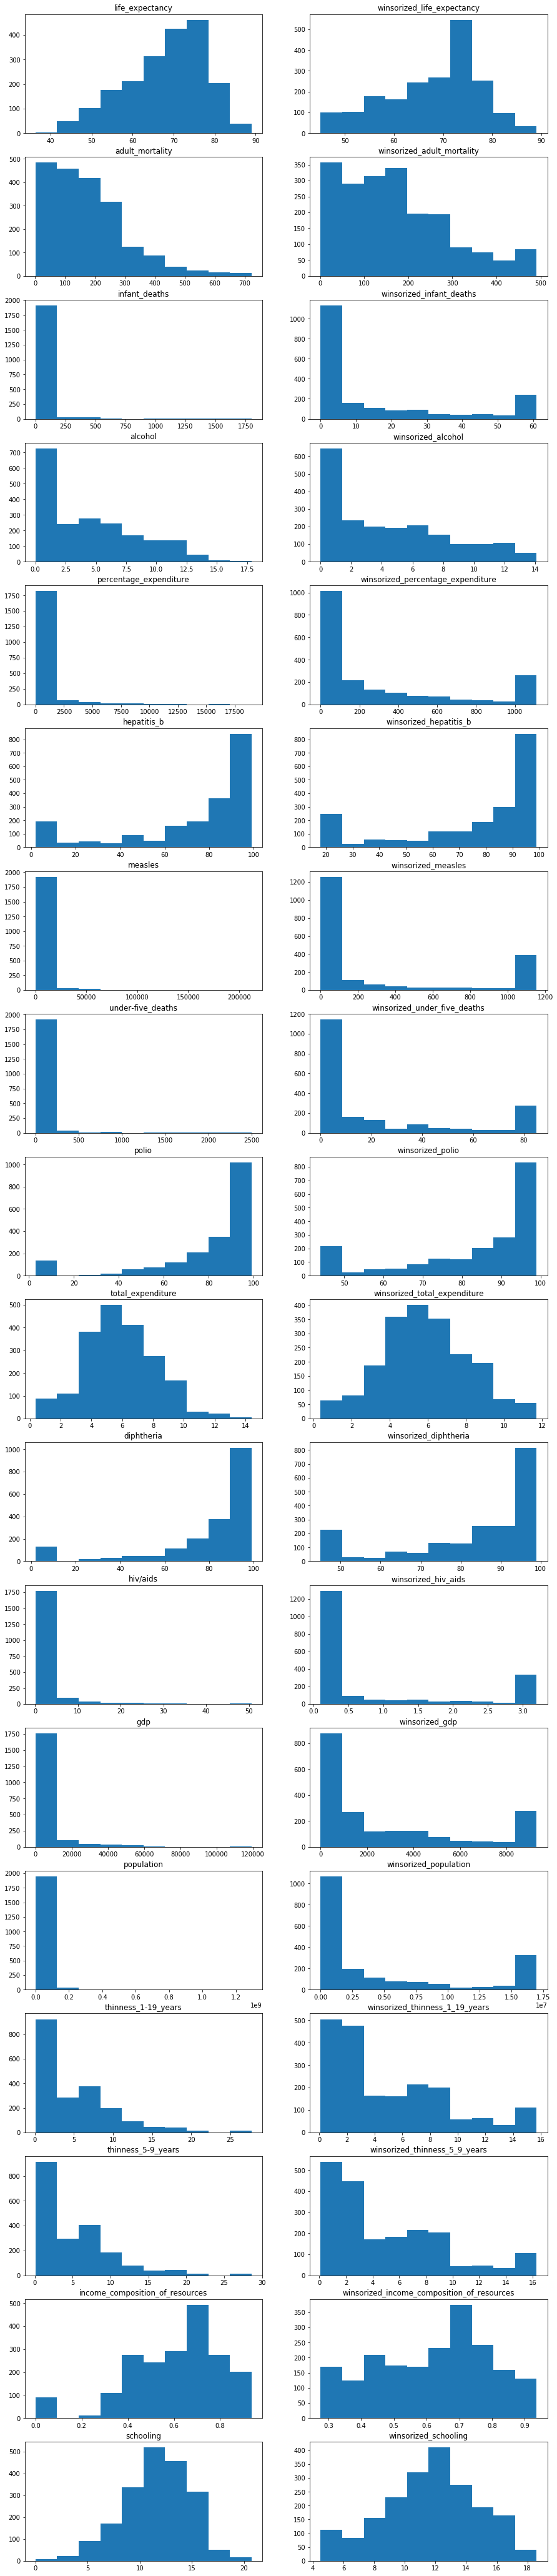

In [34]:
# Plot variables 

all_col = ['life_expectancy','winsorized_life_expectancy','adult_mortality',
          'winsorized_adult_mortality','infant_deaths','winsorized_infant_deaths',
          'alcohol','winsorized_alcohol','percentage_expenditure','winsorized_percentage_expenditure',
          'hepatitis_b','winsorized_hepatitis_b','measles','winsorized_measles',
           'under-five_deaths','winsorized_under_five_deaths','polio','winsorized_polio',
          'total_expenditure','winsorized_total_expenditure','diphtheria','winsorized_diphtheria',
          'hiv/aids','winsorized_hiv_aids','gdp','winsorized_gdp','population',
          'winsorized_population','thinness_1-19_years','winsorized_thinness_1_19_years',
          'thinness_5-9_years','winsorized_thinness_5_9_years','income_composition_of_resources',
          'winsorized_income_composition_of_resources','schooling','winsorized_schooling']

plt.figure(figsize=(15,75))

for i in range(len(all_col)):
    plt.subplot(18,2,i+1)
    plt.hist(df[all_col[i]])
    plt.title(all_col[i])

plt.show()

Majority of histograms of the original and winsorized variables are skewed distributions.  Winsorized life expectancy, winsorized total expenditure, and winsorized schooling are the closest to being normally distributed. 



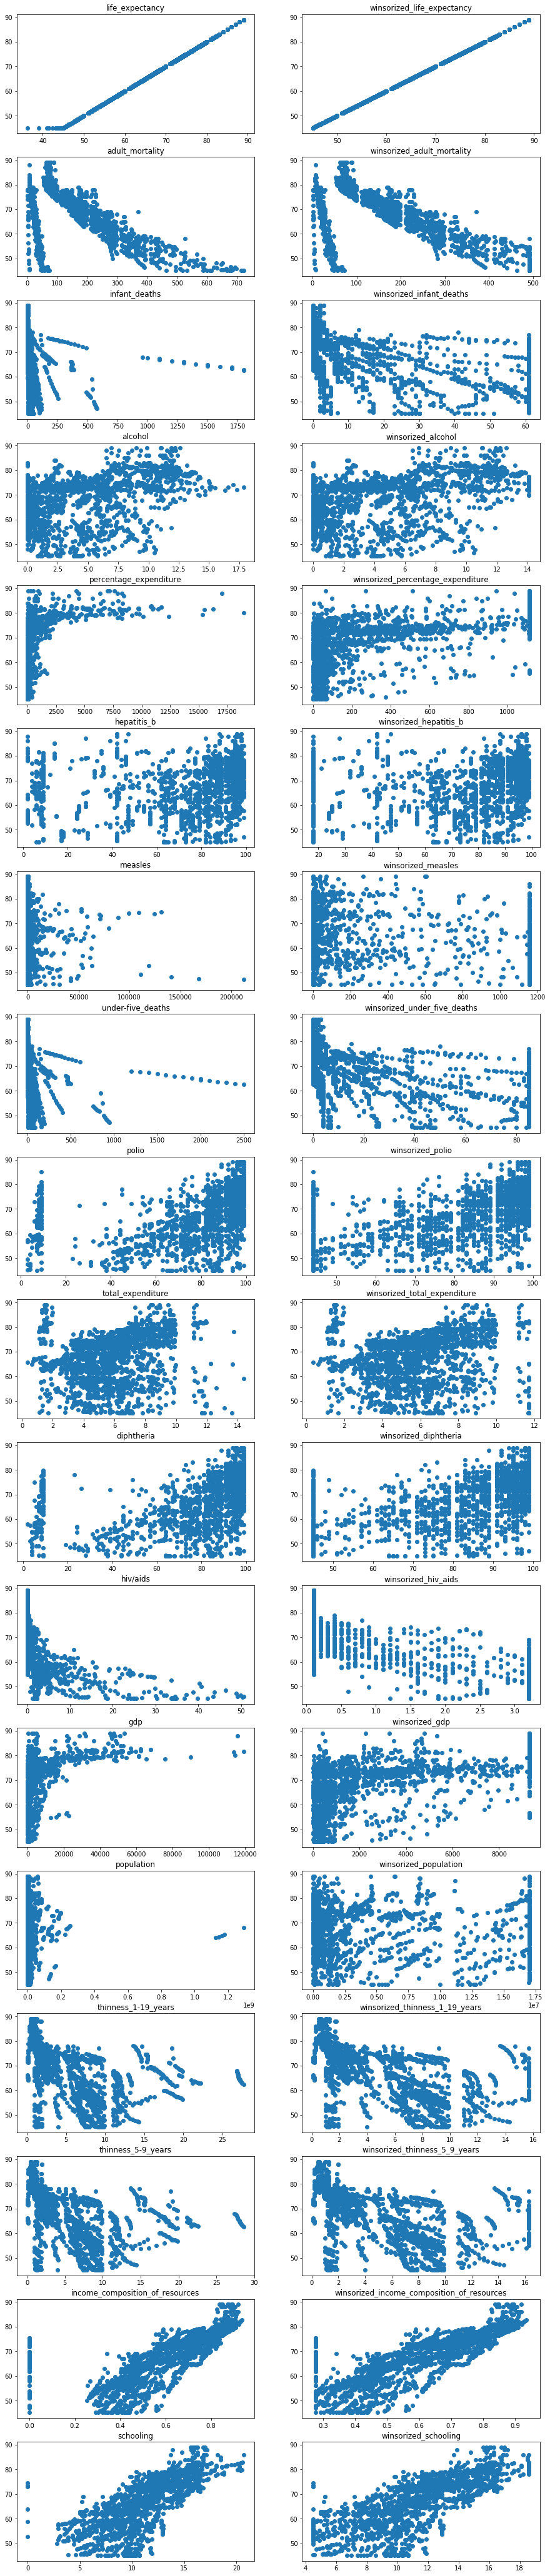

In [35]:
# Make scatterplot of winsorized life expectancy and other winsorized variables

plt.figure(figsize=(15,75))

for i in range(len(all_col)):
    plt.subplot(18,2,i+1)
    plt.scatter(df[all_col[i]],y=df['winsorized_life_expectancy'])
    plt.title(all_col[i])

plt.show()

We can observe that life expectancy has somewhat of a positive relationship with winsorized income composition of resources and schooling. Generally, countries with more resources and an educated population will have a higher standard of living and higher life expectancy. On the other hand, the relationship between life expectancy and adult morality rate is negative. This can be explained by high mortality rates decreases life expectancy. 

Finally, we'll inspect all the numeric variables together and explore the correlation between the variables to help identify relevant features.  

In [36]:
# Make coorelation matrix

win_list = df.iloc[:,[22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,
                      39]]
win_list.corr()


,winsorized_life_expectancy,winsorized_adult_mortality,winsorized_infant_deaths,winsorized_alcohol,winsorized_percentage_expenditure,winsorized_hepatitis_b,winsorized_measles,winsorized_under_five_deaths,winsorized_polio,winsorized_total_expenditure,winsorized_diphtheria,winsorized_hiv_aids,winsorized_gdp,winsorized_population,winsorized_thinness_1_19_years,winsorized_thinness_5_9_years,winsorized_income_composition_of_resources,winsorized_schooling
winsorized_life_expectancy,1.000000,-0.654255,-0.516494,0.396073,0.557117,0.268086,-0.313013,-0.552035,0.516167,0.208400,0.535687,-0.793696,0.551722,-0.040138,-0.507870,-0.498791,0.823222,0.762333
winsorized_adult_mortality,-0.654255,1.000000,0.303275,-0.191173,-0.313519,-0.113036,0.162011,0.325745,-0.275361,-0.114441,-0.274879,0.570475,-0.307826,0.045473,0.329845,0.335899,-0.488595,-0.429127
winsorized_infant_deaths,-0.516494,0.303275,1.000000,-0.301196,-0.367645,-0.192581,0.585217,0.993583,-0.373281,-0.192206,-0.369402,0.362366,-0.355888,0.423702,0.412490,0.432688,-0.478552,-0.521371
winsorized_alcohol,0.396073,-0.191173,-0.301196,1.000000,0.535143,0.113096,-0.172897,-0.304476,0.280870,0.232997,0.289133,-0.139499,0.539202,0.004264,-0.417504,-0.406472,0.590256,0.599497
winsorized_percentage_expenditure,0.557117,-0.313519,-0.367645,0.535143,1.000000,0.097402,-0.228420,-0.375608,0.287148,0.287113,0.294386,-0.310117,0.915731,-0.027779,-0.392719,-0.391349,0.630088,0.613831
winsorized_hepatitis_b,0.268086,-0.113036,-0.192581,0.113096,0.097402,1.000000,-0.212068,-0.204625,0.528167,0.132563,0.596233,-0.273668,0.130146,-0.057207,-0.155582,-0.166730,0.269518,0.282979
winsorized_measles,-0.313013,0.162011,0.585217,-0.172897,-0.228420,-0.212068,1.000000,0.581067,-0.273715,-0.175305,-0.275367,0.186120,-0.218882,0.290223,0.346025,0.352841,-0.274875,-0.336212
winsorized_under_five_deaths,-0.552035,0.325745,0.993583,-0.304476,-0.375608,-0.204625,0.581067,1.000000,-0.394037,-0.187895,-0.391011,0.399829,-0.368849,0.403557,0.422059,0.438594,-0.509527,-0.549190
winsorized_polio,0.516167,-0.275361,-0.373281,0.280870,0.287148,0.528167,-0.273715,-0.394037,1.000000,0.184363,0.835268,-0.426480,0.313125,-0.043777,-0.268903,-0.265431,0.521442,0.528211
winsorized_total_expenditure,0.208400,-0.114441,-0.192206,0.232997,0.287113,0.132563,-0.175305,-0.187895,0.184363,1.000000,0.194306,-0.076536,0.216910,-0.095577,-0.245679,-0.262533,0.212285,0.266425


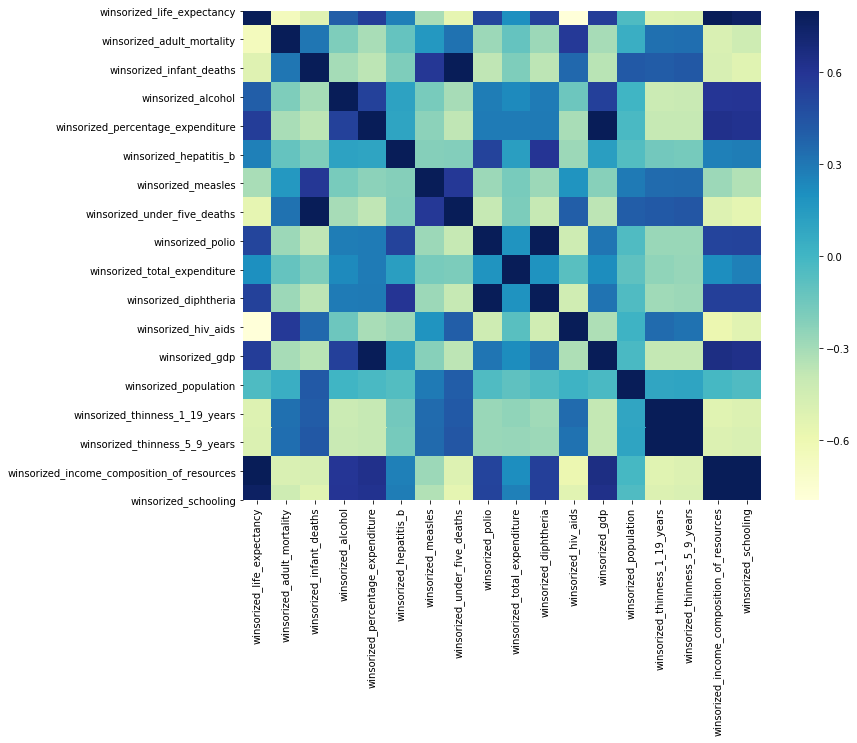

In [37]:
# Draw heatmap
corrmat = win_list.corr()

f, ax = plt.subplots(figsize=(12, 9))

sns.heatmap(corrmat, vmax=.8, square=True, cmap="YlGnBu")
plt.show()

Here, we can see correlation between winsorized life expectancy and other winsorized variables. Winsorized life expectancy and winsorized income composition of resources is the strongest positive combination (0.82). Winsorized life expectancy and winsorized schooling was a close second with a correlation of 0.76. On the other hand, winsorized life expectancy and winsorized hiv aids is the strongest negative combination (-0.79). 


Now, we will transition our focus on the remaining continuous and binary features, year and status. 

Text(0.5, 1.0, 'Winsorized Life Expectancy by Year')

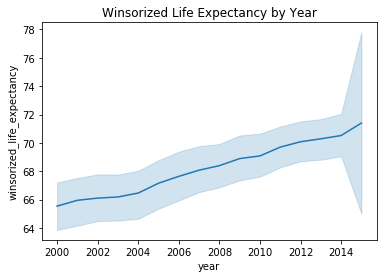

In [38]:
# Plot winsorized life expectancy by year 

ax = sns.lineplot(x="year", y="winsorized_life_expectancy",data=df)
plt.title('Winsorized Life Expectancy by Year')

In the lineplot above, we can see the average increase of life expectancy over the years with a confidence interval. 

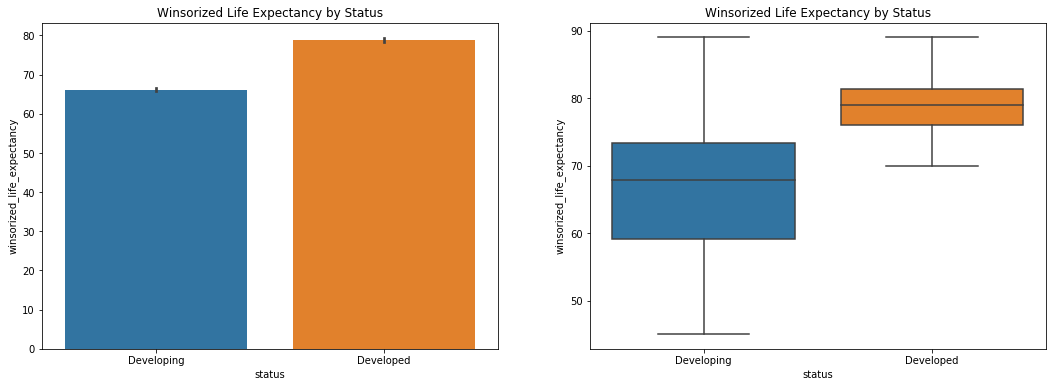

In [39]:
# Plot winsorized life expectancy by status 

plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
ax = sns.barplot(x="status", y="winsorized_life_expectancy",data=df)
plt.title('Winsorized Life Expectancy by Status')

plt.subplot(1,2,2)
ax = sns.boxplot(x="status", y="winsorized_life_expectancy",data=df)
plt.title('Winsorized Life Expectancy by Status')

plt.show()

We can see that on average, developed countries have a higher life expectancy than developing countries. The life expectancy mean score for developed countries is approximately 10 points higher thatn developing counties. 

Let's check if these means are significantly different. 

In [40]:
# Group by status 

df.groupby('status').mean()[['winsorized_life_expectancy']]

,winsorized_life_expectancy
status,
Developed,78.831579
Developing,66.187368


In [41]:
# Test whether status difference is significant

stats.ttest_ind(df.loc[df['status']=='Developed','winsorized_life_expectancy'],
                df.loc[df['status']=='Developing','winsorized_life_expectancy'],equal_var=False)

Ttest_indResult(statistic=38.10731049400164, pvalue=2.5578238020071855e-184)

Because the p-value is less than 0.05, we can assume that developed countries have higher life expectancy than developing countries 95% of the time.

## Feature Engineering 

With the information of winsorized life expectancy correlation to other variables, we will propose some feature variables. First, let's see the distribution of our target variable, life expectancy. 

Text(0.5, 1.0, 'histogram of Life Expectancy (BoxCox transformed)')

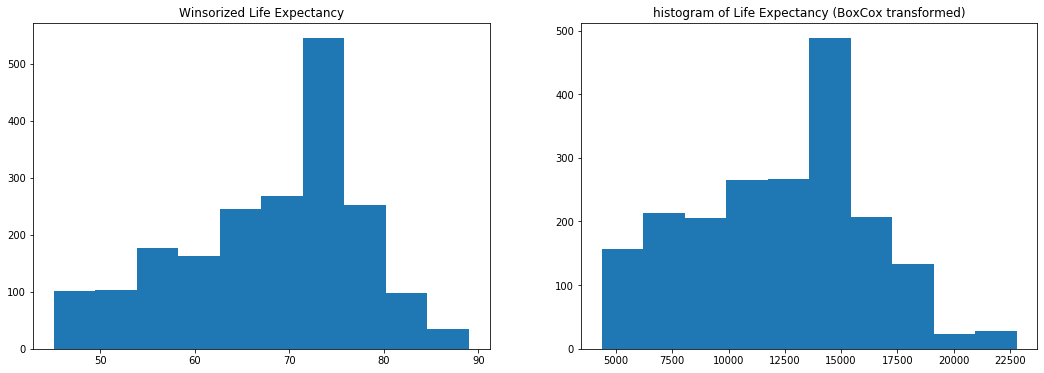

In [42]:
# Plot Life Expectancy 

from scipy.stats import boxcox
win_life_expectancy_boxcox,_ = boxcox(df["winsorized_life_expectancy"])

plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.hist(df['winsorized_life_expectancy'])
plt.title('Winsorized Life Expectancy')

plt.subplot(1,2,2)
plt.hist(win_life_expectancy_boxcox)
plt.title("histogram of Life Expectancy (BoxCox transformed)")

Since our target variable was slightly skewed to the right, we applied BoxCox transformation to approach a distribution that is closer to being normal. 

#### Feature 1: Schooling

Winsorized schooling has a relatively strong correlation with winsorized life expectancy (0.76). As shown below, the relationship between the variables is linear. The description of the variable also gives us more insight that the distribution is close to normal since mean and median are relatively close to each other.

Text(0.5, 1.0, 'Winsorized Life Expectancy by Winsorized Schooling')

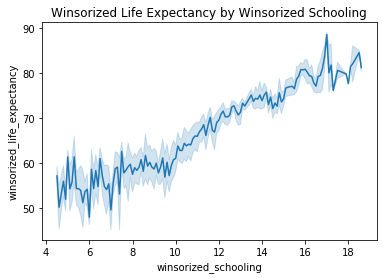

In [43]:
# Plot winsorized life expectancy by schooling 

ax = sns.lineplot(x="winsorized_schooling", y="winsorized_life_expectancy",data=df)
plt.title('Winsorized Life Expectancy by Winsorized Schooling')

In [44]:
print(df['winsorized_schooling'].describe())

count    1987.000000
mean       11.658581
std         3.102260
min         4.500000
25%         9.700000
50%        11.900000
75%        13.700000
max        18.600000
Name: winsorized_schooling, dtype: float64


#### Feature 2: Income Composition of Resources

Life expectancy and income composition of resources have the highest positive correlation (0.82). Similar to winsorized schooling, income composition of resources is also close to being normally distributed and has a linear relationship with life expectancy. 

Text(0.5, 1.0, 'Winsorized Life Expectancy by Winsorized Income of Composition of Resources')

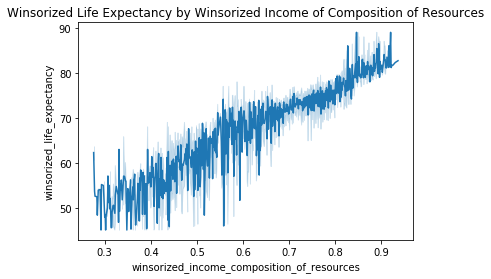

In [45]:
# Plot winsorized life expectancy by income composition of resources

ax = sns.lineplot(x="winsorized_income_composition_of_resources", y="winsorized_life_expectancy",data=df)
plt.title('Winsorized Life Expectancy by Winsorized Income of Composition of Resources')

In [46]:
print(df['winsorized_income_composition_of_resources'].describe())

count    1987.000000
mean        0.616143
std         0.174584
min         0.276000
25%         0.473000
50%         0.648000
75%         0.745000
max         0.936000
Name: winsorized_income_composition_of_resources, dtype: float64


#### Feature 3: HIV/AIDS

For the winsorized hiv/aids variable, we can see that the right skew in the distribution can be treated by prefroming Box-Cox transformation. 

Text(0.5, 1.0, 'histogram of HIV/AIDS (BoxCox transformed)')

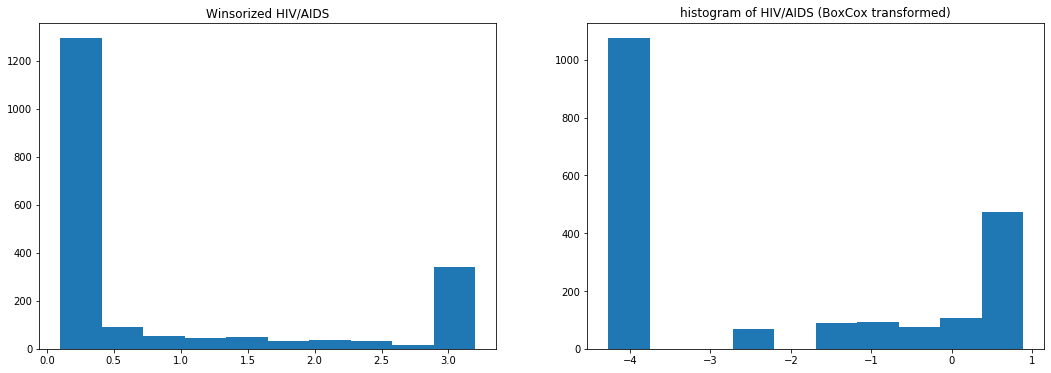

In [47]:
# Plot BoxCox HIV/AIDS

from scipy.stats import boxcox
win_hiv_aids_boxcox,_ = boxcox(df["winsorized_hiv_aids"])

plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.hist(df['winsorized_hiv_aids'])
plt.title('Winsorized HIV/AIDS')

plt.subplot(1,2,2)
plt.hist(win_hiv_aids_boxcox)
plt.title("histogram of HIV/AIDS (BoxCox transformed)")


Even after a BoxCox transformation, winsorized HIV/AIDS is still not normally distributed. For the purpose of analyzing features that affect life expectancy, additional features do not have to be normally distributed so we will continue. 

#### Feature 4: Adult Morality

Adult mortality is negatively correlated to life expectancy. We can use this as an indicator for low expectancy rates since those should also have high adult mortality rates and vise versa. This variable is also skewed to the right so we will conduct a BoxCox transformation. 

Text(0.5, 1.0, 'histogram of Adult Morality (BoxCox transformed)')

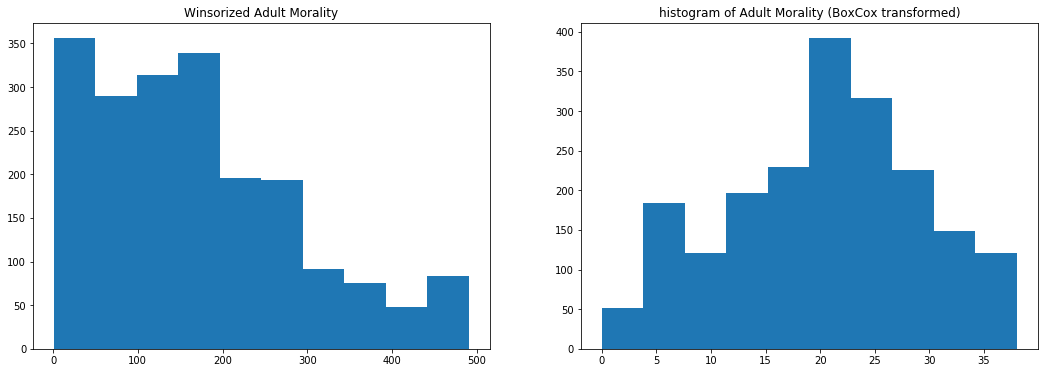

In [48]:
# Plot BoxCox Adult Morality

from scipy.stats import boxcox
win_adult_morality_boxcox,_ = boxcox(df["winsorized_adult_mortality"])

plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.hist(df['winsorized_adult_mortality'])
plt.title('Winsorized Adult Morality')

plt.subplot(1,2,2)
plt.hist(win_adult_morality_boxcox)
plt.title("histogram of Adult Morality (BoxCox transformed)")

#### Feature 5: Status

As previously discovered, status offers insight to life expectancy as countries with higher life expectancy tend to be developed countries. By nature of being a binary variable, we can see that the variable is not normally distributed. It cannot be transformed wither because the variable is categorical. 

Text(0.5, 1.0, 'Status')

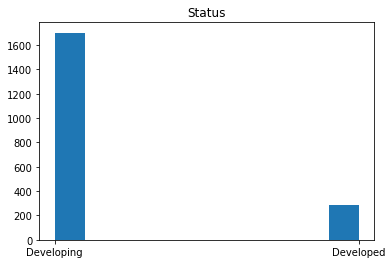

In [49]:
# Plot Status

plt.hist(df['status'])
plt.title('Status')


In [50]:
# Add BoxCox variable to the dataframe 

df['win_life_expectancy_boxcox'] = win_life_expectancy_boxcox
df['win_hiv_aids_boxcox'] = win_hiv_aids_boxcox
df['win_adult_morality_boxcox'] = win_adult_morality_boxcox


In [51]:
features_df = df[['win_life_expectancy_boxcox','status','winsorized_schooling',
                  'winsorized_income_composition_of_resources',
                'win_hiv_aids_boxcox','win_adult_morality_boxcox']]

Let's check to see if any of these variables are highly coorelated to each other than their combination with winsorized life expectancy. 

In [52]:
# Create correlation matrix for features 

features_df.corr()

,win_life_expectancy_boxcox,winsorized_schooling,winsorized_income_composition_of_resources,win_hiv_aids_boxcox,win_adult_morality_boxcox
win_life_expectancy_boxcox,1.000000,0.777707,0.835783,-0.768494,-0.557180
winsorized_schooling,0.777707,1.000000,0.886386,-0.615523,-0.386443
winsorized_income_composition_of_resources,0.835783,0.886386,1.000000,-0.644171,-0.429011
win_hiv_aids_boxcox,-0.768494,-0.615523,-0.644171,1.000000,0.476108
win_adult_morality_boxcox,-0.557180,-0.386443,-0.429011,0.476108,1.000000


We can observe that winsorized schooling is more correlated with winsorized income composition of resources than our target variable so we will drop that feature. Winsorized adult morality correlation to life expectancy is low (-0.5) so we will drop that as well. 

## Summary 

To recap, we began the EDA process by cleaning the data and identifying missing values. Since the rows were arranged in groups of data collected for a country from 2011 and 2015, we used interpolation to fill in the missing values since this was a time series dataset. After comparing descriptive statistics on before and after the dataset was interpolated, the means of variable did not drastically shift so we assume that the data was missing at random. Then, we detected outliers by plotting boxplots and set limits to extreme values with the winsorization method. To explore the relationship between life expectancy and other variables, we plotted histograms and scatterplots. We were able to see that most of the data were not normally distributed and identify some linear relationship through the scatterplots. Since the goal of this assignment is to select variables that have the most affect on life expectancy, we used a heatmap to observe the correlation between variables. After evaluating each variable to see if it was suitable for a machine learning model, we came to a decision of selecting the following variables:

__Postive features__
> - winsorized income composition of resources
> - status

__Negative features__
> - winsorized HIV/AIDS 

Before these features are ready to be used in a machine learning model, we also need to set ranges or standardize our variables since machine learning models assume all features have the same range. 